# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:7'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)

In [2]:
print(torch.__version__)

2.1.2+cu121


# Text data preparation

Let's read tinyshakespeare.txt

In [3]:
CONTEXT_SIZE = 128

In [4]:
from spiky.util.text_snippet_sampler import TextSnippetSampler

snippet_sampler = TextSnippetSampler('tinyshakespeare.txt', CONTEXT_SIZE + 1, 1000, device)

In [5]:
snippet_sampler.sample_training_batch(2)

tensor([[ 46,  10,  10,  76,  69,  79,  78,  84,  69,  83,  58,  10,  89, 111,
         117,  32, 107, 110, 101, 119,  32, 111, 102,  32, 104, 105, 115,  32,
         100, 101, 112,  97, 114, 116, 117, 114, 101,  44,  32,  97, 115,  32,
         121, 111, 117,  32, 107, 110, 111, 119,  10,  87, 104,  97, 116,  32,
         121, 111, 117,  32, 104,  97, 118, 101,  32, 117, 110, 100, 101, 114,
         116,  97,  39, 101, 110,  32, 116, 111,  32, 100, 111,  32, 105, 110,
          39, 115,  32,  97,  98, 115, 101, 110,  99, 101,  46,  10,  10,  72,
          69,  82,  77,  73,  79,  78,  69,  58,  10,  83, 105, 114,  44,  10,
          89, 111, 117,  32, 115, 112, 101,  97, 107,  32,  97,  32, 108,  97,
         110, 103, 117],
        [117,  32,  97, 114, 116,  32, 100,  97, 109, 110,  39, 100,  32, 116,
         111,  32, 104, 101, 108, 108,  32, 102, 111, 114,  32, 116, 104, 105,
         115,  46,  10,  10,  72,  69,  78,  82,  89,  32,  80,  69,  82,  67,
          89,  58,  10,  65

In [6]:
snippet_sampler.batch_to_text(snippet_sampler.sample_training_batch(4))

['Is not this well? Come, my sweet Kate:\nBetter once than never, for never too late.\n\nLUCENTIO:\nAt last, though long, our jarring n',
 ' eyes\nTo see alike mine honour as their profits,\nTheir own particular thrifts, they would do that\nWhich should undo more doing: a',
 'd her and rid the\nhouse of her! Come on.\n\nTRANIO:\nI pray, sir, tell me, is it possible\nThat love should of a sudden take such hol',
 ', it\nwill also be the bondage of certain ribbons and gloves.\n\nMOPSA:\nI was promised them against the feast; but they come\nnot too']

In [7]:
for test_batch in snippet_sampler.testing_batches_iterator(4):
    print(snippet_sampler.batch_to_text(test_batch))
    break

['range:\nNay, it is ten times true; for truth is truth\nTo the end of reckoning.\n\nDUKE VINCENTIO:\nAway with her! Poor soul,\nShe spea', 'd till he be three quarters\nand a dram dead; then recovered again with\naqua-vitae or some other hot infusion; then, raw as\nhe is,', "r, stay at the gate.\n\nJULIET:\nNow, good sweet nurse,--O Lord, why look'st thou sad?\nThough news be sad, yet tell them merrily;\nIf", " queen,\nWho crown'd the gracious duke in high despite,\nLaugh'd in his face; and when with grief he wept,\nThe ruthless queen gave "]


# Baseline autoencoder

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ByteAutoencoder(nn.Module):
    def __init__(self, C, d_model, dropout=0.1):
        super().__init__()
        self.C = C
        self.d_model = d_model

        self.embed = nn.Embedding(256, d_model)

        D = C * d_model

        self.enc = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.dec = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, D),
        )

        self.unembed = nn.Linear(d_model, 256)

    def forward(self, x):                # x: [B, C] uint8/long
        e = self.embed(x)                # [B, C, d_model]
        flat = e.reshape(e.size(0), -1)  # [B, C*d_model]

        z = self.enc(flat)
        rec_flat = self.dec(z)

        rec = rec_flat.view(-1, self.C, self.d_model)
        logits = self.unembed(rec)       # [B, C, 256]

        return logits

In [ ]:
ae = ByteAutoencoder(CONTEXT_SIZE + 1, 128)
ae.to(device)
x = torch.randint(0, 256, (4, CONTEXT_SIZE + 1), dtype=torch.long, device=device)
logits = ae(x) 
logits

In [15]:
def evaluate_model(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    # Collect all test batches first (sampler may be a generator)
    test_batches = list(sampler.testing_batches_iterator(B))

    with torch.no_grad():
        for batch in test_batches:                     # [B, C]
            tgt = batch.long()

            logits = model(batch)                      # [B, C, 256]

            B_, T, V = logits.shape
            loss = F.cross_entropy(
                logits.reshape(B_*T, V),
                tgt.reshape(B_*T)
            )
            losses.append(loss.item())

    # ---- reconstruction demo ----
    rnd_batch = test_batches[0]
    idx = torch.randint(0, rnd_batch.size(0), (1,)).item()
    sample = rnd_batch[idx:idx+1].to(device)           # [1, C]

    with torch.no_grad():
        logits = model(sample)
        pred = logits.argmax(dim=-1).cpu().numpy()[0]  # [C]

    orig = bytes(sample.cpu().tolist()[0])
    recon = bytes(pred.tolist())

    print("\n--- Reconstruction demo ---")
    print("original:     ", orig)
    print("reconstructed:", recon)
    print("----------------------------\n")

    model.train()
    return sum(losses) / len(losses)

In [ ]:
batch_size = 128
evaluate_model(ae, snippet_sampler, batch_size)

In [ ]:
total = sum(p.numel() for p in ae.parameters())
trainable = sum(p.numel() for p in ae.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch
import torch.nn.functional as F
from torch.optim import Adam, SGD

lr=0.001
#lr=0.1
#lr=1.0
steps=50_000
test_every=1000
opt = Adam([p for p in ae.parameters() if p.requires_grad], lr=lr)
# opt = SGD([p for p in baseline_net.parameters() if p.requires_grad], lr=lr)
def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

# sched = LambdaLR(opt, lr_lambda=lr_func)

In [ ]:
train_losses = []
test_losses = []
steps = 50_000

In [ ]:
pbar = tqdm(total=steps)
ae.train()
train_loss = None
alpha = 0.01

for step in range(1, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    tgt = x.long()                                          # [B, C]

    logits = ae(x)                                          # [B, C, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B*T, V),
        tgt.reshape(B*T)
    )

    opt.zero_grad()
    loss.backward()
    opt.step()

    v = loss.item()
    train_loss = v if train_loss is None else (1 - alpha)*train_loss + alpha*v

    pbar.update(1)
    if step % 100 == 0:
        pbar.set_description(f"loss={train_loss:.4f}")

    if step % test_every == 0:
        test_loss = evaluate_model(ae, snippet_sampler, batch_size)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, train_losses, label="train")
plt.plot(steps, test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simple LUT autoencoder

In [53]:
import torch
import torch.nn as nn

from spiky.lut.LUTLayer import (
    LUTLayer,
    Conv2DLUTLayer,
    LUTSharedContext,
    GradientPolicy,
    GradientType,
    MultiLUT,
    SynapseMeta
)


class LUTAutoencoder(nn.Module):
    def __init__(self, C, d_model, hidden_dim, weights_gradient_policy, dropout=0.1, device=device):
        super().__init__()
        self.C = C
        self.d_model = d_model
        self.hidden_dim = hidden_dim

        self.lut_shared_context = LUTSharedContext()
        self.lut_shared_context.to_device(device)

        D = C * d_model
        
        self.embed = nn.Embedding(256, d_model, device=device)
        self.enc = LUTLayer(
            n_inputs=D,
            n_outputs=hidden_dim,
            n_detectors=d_model * C,
            n_anchors_per_detector=5,
            weights_gradient_policy=weights_gradient_policy,
            shared_context=self.lut_shared_context,
            device=device
        )

        # ---------- Encoder ----------
        self.hidden_layers = nn.ModuleList([
            nn.Dropout(dropout),
            LUTLayer(
                n_inputs=hidden_dim,
                n_outputs=hidden_dim,
                n_detectors=hidden_dim * 8,
                n_anchors_per_detector=8,
                weights_gradient_policy=weights_gradient_policy,
                shared_context=self.lut_shared_context,
                device=device
            ),
            nn.Dropout(dropout),
            LUTLayer(
                n_inputs=hidden_dim,
                n_outputs=hidden_dim,
                n_detectors=hidden_dim * 8,
                n_anchors_per_detector=8,
                weights_gradient_policy=weights_gradient_policy,
                shared_context=self.lut_shared_context,
                device=device
            ),
            nn.Dropout(dropout),
            LUTLayer(
                n_inputs=hidden_dim,
                n_outputs=hidden_dim,
                n_detectors=hidden_dim * 8,
                n_anchors_per_detector=8,
                weights_gradient_policy=weights_gradient_policy,
                shared_context=self.lut_shared_context,
                device=device
            ),
            nn.Dropout(dropout),
            LUTLayer(
                n_inputs=hidden_dim,
                n_outputs=hidden_dim,
                n_detectors=hidden_dim * 8,
                n_anchors_per_detector=8,
                weights_gradient_policy=weights_gradient_policy,
                shared_context=self.lut_shared_context,
                device=device
            ),
            nn.Dropout(dropout),
            LUTLayer(
                n_inputs=hidden_dim,
                n_outputs=hidden_dim,
                n_detectors=hidden_dim * 8,
                n_anchors_per_detector=8,
                weights_gradient_policy=weights_gradient_policy,
                shared_context=self.lut_shared_context,
                device=device
            ),
            nn.Dropout(dropout),
        ])

        self.dec = LUTLayer(
            n_inputs=hidden_dim,
            n_outputs=D,
            n_detectors=hidden_dim * 8,
            n_anchors_per_detector=5,
            weights_gradient_policy=weights_gradient_policy,
            shared_context=self.lut_shared_context,
            device=device
        )

        self.unembed = nn.Linear(d_model, 256, device=device)

    # --------------------------------------------------------
    #                NEW FORWARD (with unsqueeze/squeeze)
    # --------------------------------------------------------
    def forward(self, x):                # x: [B, C]
        if self.d_model == 1:
            e = x.to(dtype=torch.float32) / 255
        else:
            e = self.embed(x)                # [B, C, d_model]
        flat = e.reshape(e.size(0), -1)  # [B, C*d_model]

        h = flat.unsqueeze(1)            # <-- [B, 1, D]
        h = self.enc(h)
        
        # ---------- Encoder ----------
        for layer in self.hidden_layers:
            h = layer(h) + h
        
        h = self.dec(h).squeeze(1)

        rec = h.view(-1, self.C, self.d_model)  # [B, C, d_model]
        logits = self.unembed(rec)              # [B, C, 256]
        return logits


In [54]:
from spiky.lut.LUTLayer import GradientPolicy, GradientType
lut_autoencoder = None
optimizer = None
sched = None
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
lut_autoencoder = LUTAutoencoder(
    C=CONTEXT_SIZE+1,
    d_model=1,
    hidden_dim=32,
    weights_gradient_policy=GradientPolicy(GradientType.Dense),
    dropout=0.1,
    device=device
)
print(lut_autoencoder)

LUTAutoencoder(
  (embed): Embedding(256, 1)
  (enc): LUTLayer(129 inputs, 129 detectors, 32 outputs, 5 anchors per detector)
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): LUTLayer(32 inputs, 256 detectors, 32 outputs, 8 anchors per detector)
    (2): Dropout(p=0.1, inplace=False)
    (3): LUTLayer(32 inputs, 256 detectors, 32 outputs, 8 anchors per detector)
    (4): Dropout(p=0.1, inplace=False)
    (5): LUTLayer(32 inputs, 256 detectors, 32 outputs, 8 anchors per detector)
    (6): Dropout(p=0.1, inplace=False)
    (7): LUTLayer(32 inputs, 256 detectors, 32 outputs, 8 anchors per detector)
    (8): Dropout(p=0.1, inplace=False)
    (9): LUTLayer(32 inputs, 256 detectors, 32 outputs, 8 anchors per detector)
    (10): Dropout(p=0.1, inplace=False)
  )
  (dec): LUTLayer(32 inputs, 256 detectors, 129 outputs, 5 anchors per detector)
  (unembed): Linear(in_features=1, out_features=256, bias=True)
)


In [55]:
total = sum(p.numel() for p in lut_autoencoder.parameters())
trainable = sum(p.numel() for p in lut_autoencoder.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 11675392
trainable: 11675392
frozen: 0


In [56]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from spiky.util.torch_utils import make_lr_getter

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

#optimizer = optim.SGD(lut_transformer.parameters(), lr=1.0)
#sched = LambdaLR(optimizer, lr_lambda=lr_func)
#lut_transformer.set_external_learning_rate_hook(make_lr_getter(optimizer))
opt = optim.Adam(lut_autoencoder.parameters(), lr=0.001)
batch_size = 32

In [57]:
lut_train_losses = []
lut_test_losses = []

In [58]:
steps=50000
test_every=1000
train_loss = None
alpha = 0.01
pbar = tqdm(total=steps)
lut_autoencoder.train()

for step in range(1, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    tgt = x.long()                                          # [B, C]

    logits = lut_autoencoder(x)                                          # [B, C, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B*T, V),
        tgt.reshape(B*T)
    )

    opt.zero_grad()
    loss.backward()
    opt.step()

    v = loss.item()
    train_loss = v if train_loss is None else (1 - alpha)*train_loss + alpha*v

    pbar.update(1)
    if step % 100 == 0:
        pbar.set_description(f"loss={train_loss:.4f}")

    if step % test_every == 0:
        test_loss = evaluate_model(lut_autoencoder, snippet_sampler, batch_size)
        lut_train_losses.append(train_loss)
        lut_test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")


  0%|          | 0/50000 [00:00<?, ?it/s]


--- Reconstruction demo ---
original:      b" of Bolingbroke\nIt is, such crimson tempest should bedrench\nThe fresh green lap of fair King Richard's land,\nMy stooping duty ten"
reconstructed: b'                                                                                                                                 '
----------------------------

[TEST] step 1000: loss=3.3024

--- Reconstruction demo ---
original:      b'\nI have it, Tranio.\n\nTRANIO:\nMaster, for my hand,\nBoth our inventions meet and jump in one.\n\nLUCENTIO:\nTell me thine first.\n\nTRAN'
reconstructed: b'                                                                                                                                 '
----------------------------

[TEST] step 2000: loss=3.2519

--- Reconstruction demo ---
original:      b'd till he be three quarters\nand a dram dead; then recovered again with\naqua-vitae or some other hot infusion; then, raw as\nhe is,'
reconstructed: b'                    


--- Reconstruction demo ---
original:      b".\n\nBRUTUS:\nDismiss them home.\nHere comes his mother.\n\nSICINIUS:\nLet's not meet her.\n\nBRUTUS:\nWhy?\n\nSICINIUS:\nThey say she's mad.\n"
reconstructed: b'\n\n\n\n\n\n\n\n\n\n                                            \n\n\n                                        \n\n \n\n\n\n\n\n\n\n\n\n                   '
----------------------------

[TEST] step 22000: loss=3.1438

--- Reconstruction demo ---
original:      b"sing of blood-sucking sighs,\nLest with my sighs or tears I blast or drown\nKing Edward's fruit, true heir to the English crown.\n\nR"
reconstructed: b'                                                                                                                      \n\n\n        '
----------------------------

[TEST] step 23000: loss=3.1430

--- Reconstruction demo ---
original:      b"re Isabel! should it then be thus?\nNo; I would tell what 'twere to be a judge,\nAnd what a prisoner.\n\nLUCIO:\n\nANGELO:\nYour brother

KeyboardInterrupt: 

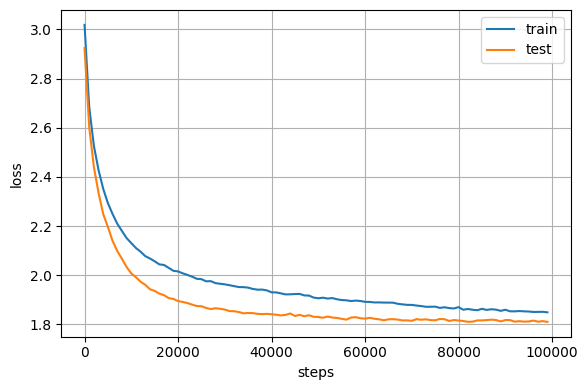

In [30]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
generate_text_lut(lut_transformer, 'Once upon a time: ', length=80, device=device)

In [ ]:
print(lut_transformer.get_profile_statistics())

In [ ]:
evaluate_model(lut_transformer, snippet_sampler, 4)

In [ ]:
w = torch.rand([16, 1 << (6 + 6 + 4), 32])
w.shape

In [ ]:
inp = torch.rand([128, 1024, 32])
inp.shape

In [ ]:
after_d = torch.rand([128, 1024, 16, 65536], device=device)
after_d.shape